In [212]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
from tgirt_map.table_tools import change_gene_type
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from sequencing_tools.stats_tools import normalize_count
from collections import defaultdict
import re
import glob
import os
from tgirt_map.table_tools import change_gene_type
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, \
                        figure_path
from count_plot import plot_insert, plot_coding_bases, plot_strand, plot_count, \
                    sample_wise_fraction,plot_small_count_pie, read_count, plot_small_count_bar,\
                    recat_rRNA, label_order
from matplotlib import rcParams
from scipy.stats import pearsonr, spearmanr
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# insert size

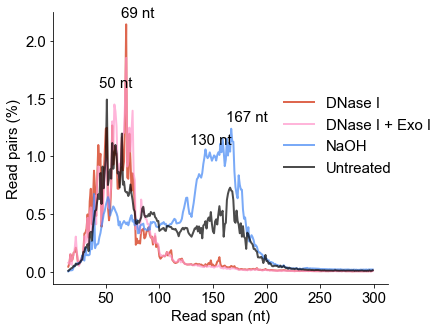

In [213]:
fig = plt.figure(figsize = (6,5))
ax_insert = fig.add_subplot(111)
idf = plot_insert(ax_insert, samples = ['DNase I', 'DNase I + Exo I',
                                       'NaOH', 'Untreated', 'Unfragmented'])#,
                                     # "DNase I - 3'P" ])
sns.despine()
#ax_insert.set_ylim(0,2)
ax_insert.text(64, 2.2, '69 nt', fontsize=15)
ax_insert.text(44, 1.6, '50 nt', fontsize=15)
ax_insert.text(162, 1.3, '167 nt', fontsize=15)
ax_insert.text(129, 1.1, '130 nt', fontsize=15)

fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

In [214]:
idf.groupby('label').apply(lambda d: d[d.size_fraction==d.size_fraction.max()])

,,label,isize,size_fraction
label,,,,
DNase I,4321,DNase I,69,2.140200
DNase I + Exo I,909,DNase I + Exo I,69,1.850043
NaOH,152,NaOH,167,1.236227
Untreated,4588,Untreated,51,1.489092


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


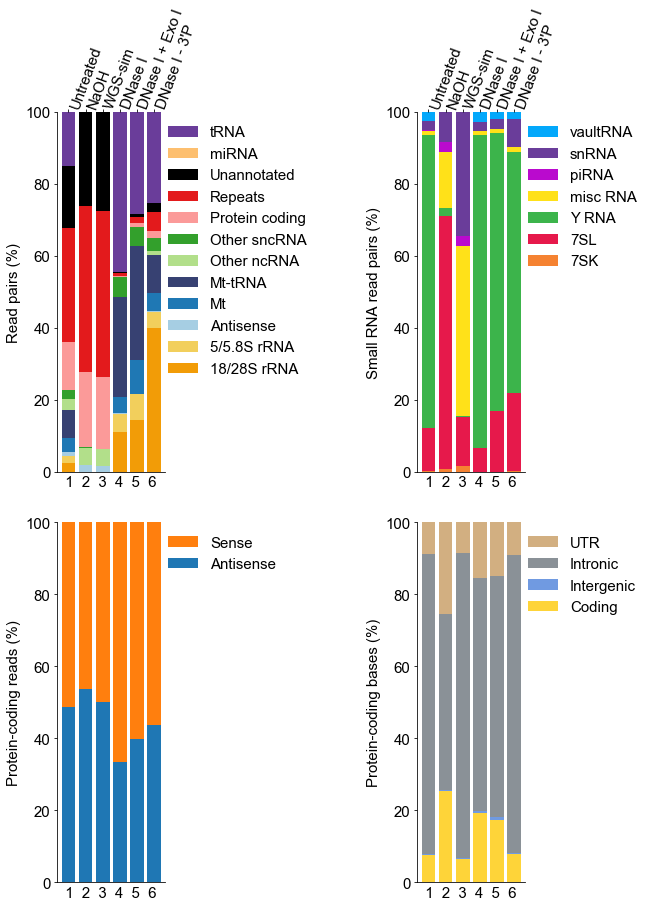

In [216]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_small_RNA = fig.add_axes([0.5, 0.52, 0.15,0.5])
ax_strand = fig.add_axes([0,-0.05,0.15,0.5])
ax_coding = fig.add_axes([0.5, -0.05, 0.15, 0.5])


cdf = plot_count(ax_frag_dist, feature_only=False)
#cdf = plot_count(ax_frag_dist_feature_only, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
plot_small_count_bar(ax_small_RNA)
ax_small_RNA.set_ylim(0,100)
ax_strand.xaxis.set_visible(False)
ax_coding.xaxis.set_visible(False)
ax_coding.set_ylim(0,100)
ax_strand.set_ylim(0,100)
ax_frag_dist.xaxis.tick_top()
#ax_frag_dist_feature_only.xaxis.tick_top()
ax_small_RNA.xaxis.tick_top()
fig.text(0,0.5,'  1  2  3  4  5  6', fontsize=15)
fig.text(0.5,0.5,'  1  2  3  4  5  6', fontsize=15)
fig.text(0, -0.07,'  1  2  3  4  5  6', fontsize=15)
fig.text(0.5, -0.07,'  1  2  3  4  5  6', fontsize=15)


#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

In [174]:
small_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/all_counts.feather') \
        .query("dedup == 'dedup'")\
        .assign(grouped_type = lambda d: d.gene_type.map(change_gene_type)) \
        .assign(grouped_type = lambda d: list(map(recat_rRNA, d.gene_name, d.grouped_type)))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-T'),'Mt-tRNA', d.grouped_type))\
        .groupby(['gene_type','grouped_type','samplename'], as_index=False)\
        .agg({'read_count':'sum'})
small_df.head()

,gene_type,grouped_type,samplename,read_count
0,18S_rRNA,18/28S rRNA,GC_R1_001,8249
1,18S_rRNA,18/28S rRNA,IGG-cf_R1_001,1035
2,18S_rRNA,18/28S rRNA,MPCEV_R1_001,85106
3,18S_rRNA,18/28S rRNA,MPF10_R1_001,12961
4,18S_rRNA,18/28S rRNA,MPF4_R1_001,13172


In [183]:
detail = True
gt = 'grouped_type' if not detail else 'gene_type'
grouped_fraction = small_df\
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(frag_frac = lambda d: d.groupby(['samplename'])\
                .read_count\
                .transform(lambda x: 100*x/x.sum())) \
    .groupby(['prep','gene_type'], as_index=False)\
    .agg({'frag_frac':['min','max']})
grouped_fraction.head()
grouped_fraction \
    .pipe(lambda d: d[d.prep=="DNase I"])

prep                           gene_type  frag_frac           
                                                       min        max
0   DNase I                            18S_rRNA   1.435117   5.061093
1   DNase I                            28S_rRNA   2.978549  12.984232
2   DNase I            3prime_overlapping_ncRNA   0.000023   0.000325
3   DNase I                           5.8S_rRNA   1.161817   4.876949
4   DNase I                             5S_rRNA   1.054033   2.724666
5   DNase I                                 7SK   0.000493   0.010021
6   DNase I                                 7SL   0.124963   0.482827
7   DNase I                           IG_C_gene   0.000087   0.000341
8   DNase I                     IG_C_pseudogene   0.000035   0.000059
9   DNase I                           IG_D_gene   0.000058   0.000058
10  DNase I                           IG_J_gene   0.000027   0.000069
11  DNase I                           IG_V_gene   0.000035   0.000266
12  DNase I                     IG_V_pseudogene   0.000035   0.000104
13  DNase I                             Mt_rRNA   3.133297   8.594389
14  DNase I                             Mt_tRNA  18.940514  49.515998
15  DNase I                         No features   0.143580   0.655632
16  DNase I                             Repeats   0.000207   1.734474
17  DNase I                                 TEC   0.000311   0.001377
18  DNase I                           TR_C_gene   0.000020   0.000080
19  DNase I                           TR_J_gene   0.000017   0.000089
20  DNase I                           TR_V_gene   0.000017   0.000153
21  DNase I                     TR_V_pseudogene   0.000024   0.000024
22  DNase I                               Y-RNA   2.722014   4.643872
23  DNase I                           antisense   0.016829   0.057061
24  DNase I       bidirectional_promoter_lncRNA   0.000114   0.000849
25  DNase I                             lincRNA   0.036474   0.109326
26  DNase I                        macro_lncRNA   0.000027   0.000038
27  DNase I                               miRNA   0.002959   0.016962
28  DNase I                            misc_RNA   0.009982   0.120362
29  DNase I                               piRNA   0.000682   0.001358
30  DNase I              polymorphic_pseudogene   0.000069   0.000412
31  DNase I                processed_pseudogene   0.014907   0.045732
32  DNase I                processed_transcript   0.005771   0.012326
33  DNase I                      protein_coding   0.000017   1.245068
34  DNase I                          pseudogene   0.000536   0.001767
35  DNase I                                rRNA   0.000023   0.000023
36  DNase I                      sense_intronic   0.000484   0.002135
37  DNase I                   sense_overlapping   0.000551   0.002318
38  DNase I                               snRNA   0.041740   0.147335
39  DNase I                              snoRNA   0.004370   0.019282
40  DNase I                                tRNA   0.001820  56.692426
41  DNase I    transcribed_processed_pseudogene   0.001209   0.007491
42  DNase I      transcribed_unitary_pseudogene   0.000380   0.002020
43  DNase I  transcribed_unprocessed_pseudogene   0.003283   0.009824
44  DNase I     translated_processed_pseudogene   0.000024   0.000086
45  DNase I                  unitary_pseudogene   0.000017   0.000407
46  DNase I              unprocessed_pseudogene   0.003804   0.007549
47  DNase I                            vaultRNA   0.068123   0.164400

Written /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/smallRNA_pie.pdf


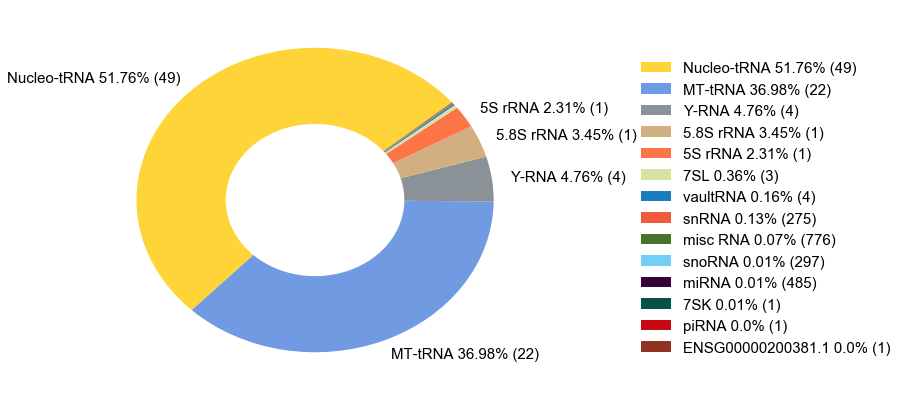

In [97]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plot_small_count_pie(ax)
figurename = figure_path + '/smallRNA_pie.pdf'
fig.savefig(figurename, bbox_inches='tight')
print('Written %s' %figurename)

# plot EV#

In [227]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/all_counts.feather', nthreads=24) \
    .query('dedup == "dedup"')\
    .pipe(lambda d: d[d.samplename.str.contains('Qcf|EV|PF')]) \
    .assign(grouped_type = lambda d: d.gene_type.map(change_gene_type)) \
    .assign(prep = lambda d: d.samplename.map(label_sample))
dedup_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,samplename,strand,gene_type,gene_name,gene_id,dedup,read_count,grouped_type,prep
192751,MPCEV_R1_001,antisense,7SK,RN7SK,RN7SK,dedup,6,Other sncRNA,Crude
192753,MPCEV_R1_001,antisense,7SL,RN7SL1,RN7SL1,dedup,66,Other sncRNA,Crude
192755,MPCEV_R1_001,antisense,7SL,RN7SL2,RN7SL2,dedup,70,Other sncRNA,Crude
192757,MPCEV_R1_001,antisense,7SL,RN7SL3,RN7SL3,dedup,23,Other sncRNA,Crude
192759,MPCEV_R1_001,antisense,IG_V_pseudogene,IGHVIII-67-4,ENSG00000254052.1_2,dedup,1,Other ncRNA,Crude


In [221]:
dedup_df.prep.unique()

array(['Crude', 'RNP', 'EV', None, 'Crude (MNase)', 'RNP (MNase)',
       'EV (MNase)', 'DNase I', 'Untreated', 'DNase I + Exo I',
       'Fragmented', 'High salt (450mM)', 'Poly(A)-selected', 'NaOH',
       "DNase I - 3'P"], dtype=object)

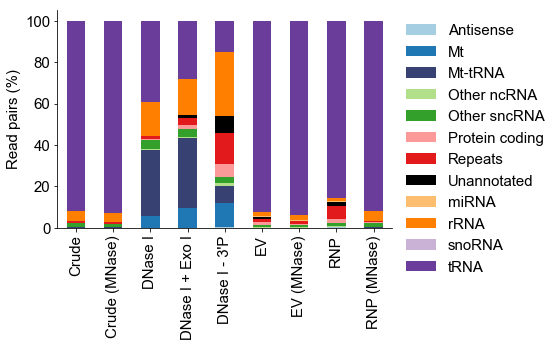

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)
type_df = dedup_df\
    .pipe(lambda d: d[~pd.isnull(d.prep)])\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP|Crude')])\
    .assign(grouped_type = lambda d: np.where((d.gene_name.str.contains('MT')) & (d.grouped_type=="tRNA"),
                    'Mt-tRNA',d.grouped_type))\
    .groupby(['grouped_type','prep'], as_index=False)\
    .agg({'read_count':'sum'}) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type=="No features",'Unannotated',d.grouped_type))\
    .assign(read_fraction = lambda d: d.groupby('prep').read_count.transform(lambda x: 100*x/x.sum()))  \
    .sort_values('prep')\
    .pipe(pd.pivot_table, index='prep', columns = 'grouped_type', values = 'read_fraction') 
colors = rna_type_ce.transform(type_df.columns).tolist()
type_df.plot.bar(stacked=True, color = colors, ax = ax)
ax.legend(bbox_to_anchor=(1,1), frameon=False, fontsize=15)
ax.set_ylabel('Read pairs (%)')
ax.set_xlabel('')
sns.despine()
fig.savefig(figure_path + '/EV_count.pdf', bbox_inches='tight')

In [225]:
from sequencing_tools.stats_tools import normalize_count

comp_df = dedup_df\
    .pipe(lambda d: d[~pd.isnull(d.prep)])\
    .pipe(lambda d: d[d.prep.str.contains('DNase I$|RNP|EV|Crude')]) \
    .pipe(lambda d: d[d.grouped_type != "rRNA"])\
    .query('gene_type != "No features"')\
    .groupby(['gene_name','gene_id','grouped_type','prep'], as_index=False)\
    .agg({'read_count':'sum'})\
    .pipe(pd.pivot_table, index=['gene_name','gene_id', 'grouped_type'],
         values = 'read_count', columns = 'prep', fill_value=0)\
    .pipe(normalize_count)\
    .reset_index()\
    .assign(grouped_type = lambda d: np.where((d.gene_name.str.contains('MT')) & (d.grouped_type=="tRNA"),
                    'Mt-tRNA',d.grouped_type))\
    .pipe(pd.melt,id_vars = ['DNase I','gene_name','gene_id','grouped_type'], 
          var_name = 'prep', value_name = 'norm_count')  \
    .assign(prep = lambda d: d.prep.str.replace('EV\+RNP|RNP\+EV','Crude')) \
    .sort_values('prep') 
comp_df.head()

,DNase I,gene_name,gene_id,grouped_type,prep,norm_count
23116,0.000000,RP11-416N13.1,ENSG00000224172.1_4,Other ncRNA,Crude,0.0
23115,0.861079,RP11-416K24.2,ENSG00000231684.3_3,Other ncRNA,Crude,0.0
23114,0.000000,RP11-416I2.1,ENSG00000260328.1_4,Other ncRNA,Crude,0.0
23113,0.172216,RP11-416A17.6,ENSG00000257246.1_3,Other ncRNA,Crude,0.0
23112,0.344431,RP11-415J8.5,ENSG00000233246.1_4,Antisense,Crude,0.0


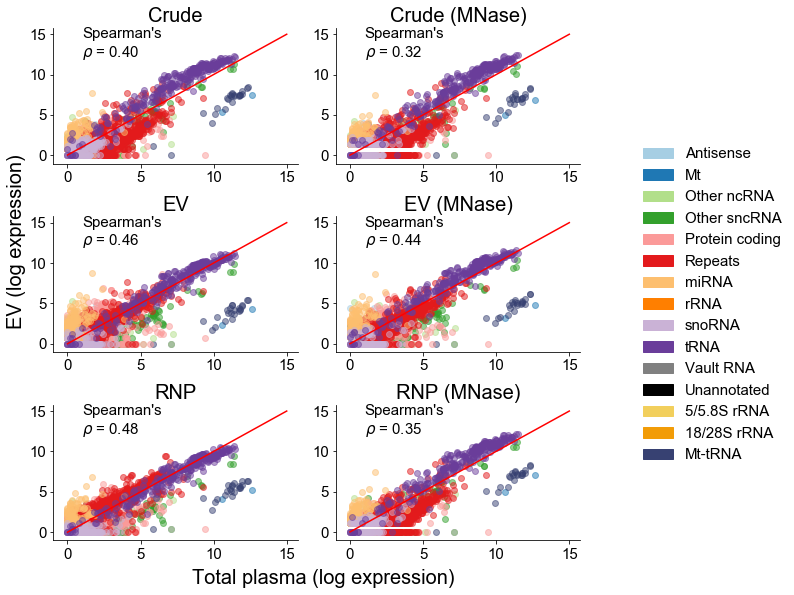

In [226]:
fig = plt.figure(figsize=(8,8))
rna_type_ce
for i, (prep, prep_df) in enumerate(comp_df.groupby('prep')):
    ax = fig.add_subplot(3,2,i+1)
    
    for gt, gtdf in prep_df.groupby('grouped_type'):
        color = rna_type_ce.encoder[gt]
        xs = np.log(gtdf['DNase I']+1)
        ys = np.log(gtdf['norm_count']+1)
        ax.scatter(xs, ys, color = color, alpha=0.5)
    r, p = spearmanr(np.log(prep_df['DNase I']+1),
             np.log(prep_df['norm_count']+1))
    ax.plot([0,15],[0,15], color = 'red')
    ax.set_title(prep, size=20)
    ax.text(1,12, "Spearman's\n" r'$\rho$ = %.2f' %r, fontsize=15)
fig.tight_layout()
sns.despine()
rna_type_ce.show_legend(ax = ax, bbox_to_anchor = (1.2,3), frameon=False,
                       fontsize=15)
fig.text(-0.02,0.7, 'EV (log expression)', fontsize=20, rotation=90)
fig.text(0.3, -0.02, 'Total plasma (log expression)', fontsize=20)
fig.savefig(figure_path + '/EV_scatter_gene.png', bbox_inches='tight')

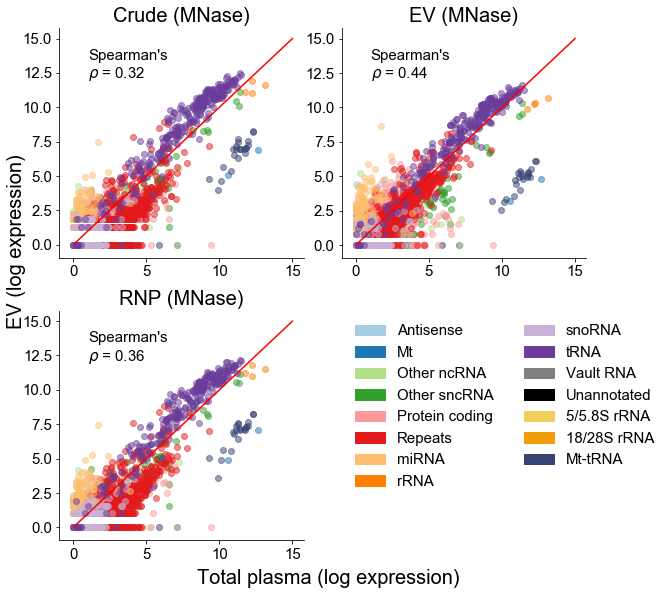

In [200]:
fig = plt.figure(figsize=(8,8))
rna_type_ce
for i, (prep, prep_df) in enumerate(comp_df\
                            .pipe(lambda d: d[d.prep.str.contains('MNase')])\
                            .groupby('prep')):
    ax = fig.add_subplot(2,2,i+1)
    
    for gt, gtdf in prep_df.groupby('grouped_type'):
        color = rna_type_ce.encoder[gt]
        xs = np.log(gtdf['DNase I']+1)
        ys = np.log(gtdf['norm_count']+1)
        ax.scatter(xs, ys, color = color, alpha=0.5)
    r, p = spearmanr(np.log(prep_df['DNase I']+1),
             np.log(prep_df['norm_count']+1))
    ax.plot([0,15],[0,15], color = 'red')
    ax.set_title(prep, size=20)
    ax.text(1,12, "Spearman's\n" r'$\rho$ = %.2f' %r, fontsize=15)
fig.tight_layout()
sns.despine()
ax = fig.add_subplot(2,2,4)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
rna_type_ce.show_legend(ax = ax, frameon=False,
                       fontsize=15, ncol=2,
                       loc='upper left')
fig.text(-0.03,0.7, 'EV (log expression)', fontsize=20, rotation=90)
fig.text(0.3, -0.02, 'Total plasma (log expression)', fontsize=20)
fig.savefig(figure_path + '/EV_mnase_scatter_gene.png', bbox_inches='tight')

In [211]:
comp_df\
    .pipe(lambda d: d[d.prep.str.contains('MNase')])\
    .groupby(['grouped_type','prep'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .assign(frac = lambda d: d.groupby('prep').norm_count.transform(lambda x: 100*x/x.sum())) \
    .groupby(['grouped_type'], as_index=False)\
    .agg({'frac':['min','max']})

grouped_type       frac           
                          min        max
0        Antisense   0.009168   0.034549
1               Mt   0.003043   0.016807
2          Mt-tRNA   0.071991   0.359961
3      Other ncRNA   0.027095   0.078654
4     Other sncRNA   1.351073   2.121031
5   Protein coding   0.143869   0.468253
6          Repeats   0.594734   1.129368
7            miRNA   0.038274   0.204556
8             rRNA   2.687864   4.606717
9           snoRNA   0.002439   0.003935
10            tRNA  92.008228  93.968211

In [107]:
dedup_df \
    .pipe(lambda d: d[~d.samplename.str.contains('[qQ][cC][fF][0-9]_')]) \
    .pipe(lambda d: d[d.samplename.str.contains('[qQ][cC][fF][0-9]+_')])\
    .samplename.unique()

array(['Qcf10_R1_001', 'Qcf11_R1_001', 'Qcf12_R1_001', 'Qcf13_R1_001'],
      dtype=object)

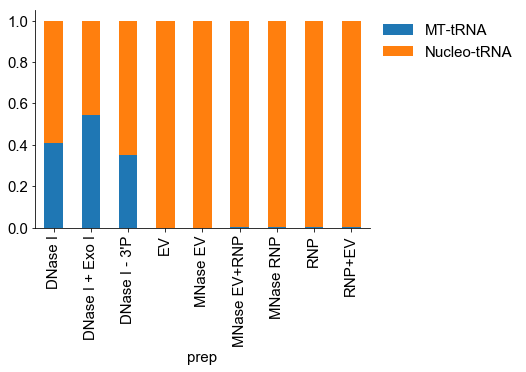

In [109]:
ax = plt.subplot()
dedup_df \
    .pipe(lambda d: d[~pd.isnull(d.prep)])\
    .pipe(lambda d: d[~d.samplename.str.contains('[qQ][cC][fF][0-9]_')])\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')]) \
    .query('grouped_type == "tRNA"')\
    .assign(is_mt = lambda d: np.where(d.gene_name.str.contains('MT'), 'MT-tRNA','Nucleo-tRNA')) \
    .groupby(['prep','is_mt'], as_index=False)\
    .agg({'read_count':'sum'}) \
    .assign(read_fraction = lambda d: d.groupby('prep').read_count.transform(lambda x: x/x.sum()))\
    .pipe(pd.pivot_table, columns = 'is_mt', index='prep', values='read_fraction')\
    .plot.bar(stacked=True, ax=ax)
ax.legend(bbox_to_anchor = (1,1), frameon=False, fontsize=15, title='')
sns.despine()

In [213]:
from sequencing_tools.viz_tools import cor_plot
from sequencing_tools.stats_tools import normalize_count

spreaded_df = dedup_df\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')]) \
    .assign(gene_name = lambda d: d.gene_name.str.replace('-[0-9]+',''))\
    .groupby(['prep','gene_name','grouped_type'], as_index=False)\
    .agg({'read_count':'sum'})\
    .pipe(pd.pivot_table, columns = 'prep', values = 'read_count',
         index=['gene_name','grouped_type'], fill_value = 0)  
spreaded_df.head()

,prep,DNase I,DNase I + Exo I,DNase I - 3'P,EV,MNase EV,MNase EV+RNP,MNase RNP,RNP,RNP+EV
gene_name,grouped_type,,,,,,,,,
.,No features,149258,185946,1706664,3698,8046,1412,2166,14272,2564
18S_rRNA,rRNA,1202564,560670,1419974,1756,2316,23452,32369,1984,5231
28S_rRNA,rRNA,2956836,1080233,4228863,2898,3985,39902,53001,3825,8236
5.8S_rRNA,rRNA,1160434,346578,500893,3004,4516,54801,70419,4826,6675
5S_rRNA,rRNA,720550,284193,227442,1847,2623,24533,38613,2485,3712


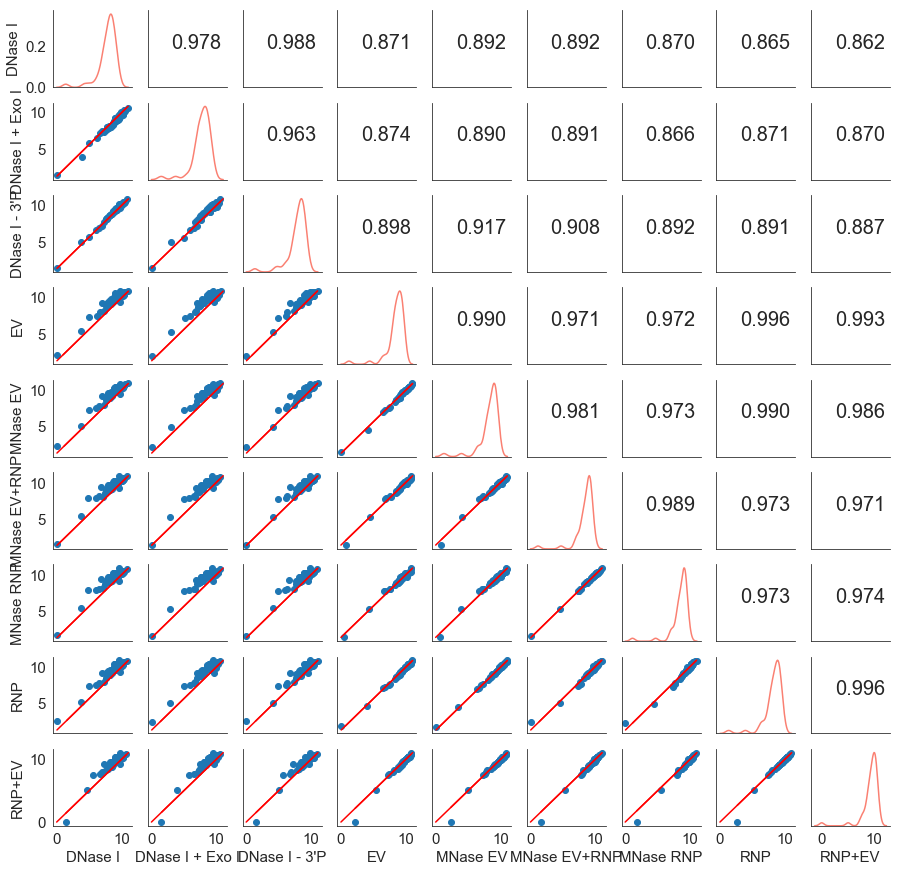

In [214]:
fig = plt.figure(figsize=(15,15))
spreaded_df\
    .reset_index()\
    .query('grouped_type == "tRNA"')\
    .drop('grouped_type', axis=1)\
    .set_index('gene_name')\
    .transform(lambda x: x/x.sum(axis=0)*1e6)\
    .transform(lambda x: np.log(x+1)) \
    .reset_index()\
    .pipe(lambda d: d[~d.gene_name.str.contains('^MT')])\
    .drop(['gene_name'], axis=1) \
    .pipe(cor_plot, fig, method = 'spearman')


Text(0.1,0.86,"Pearson's $\\rho$")

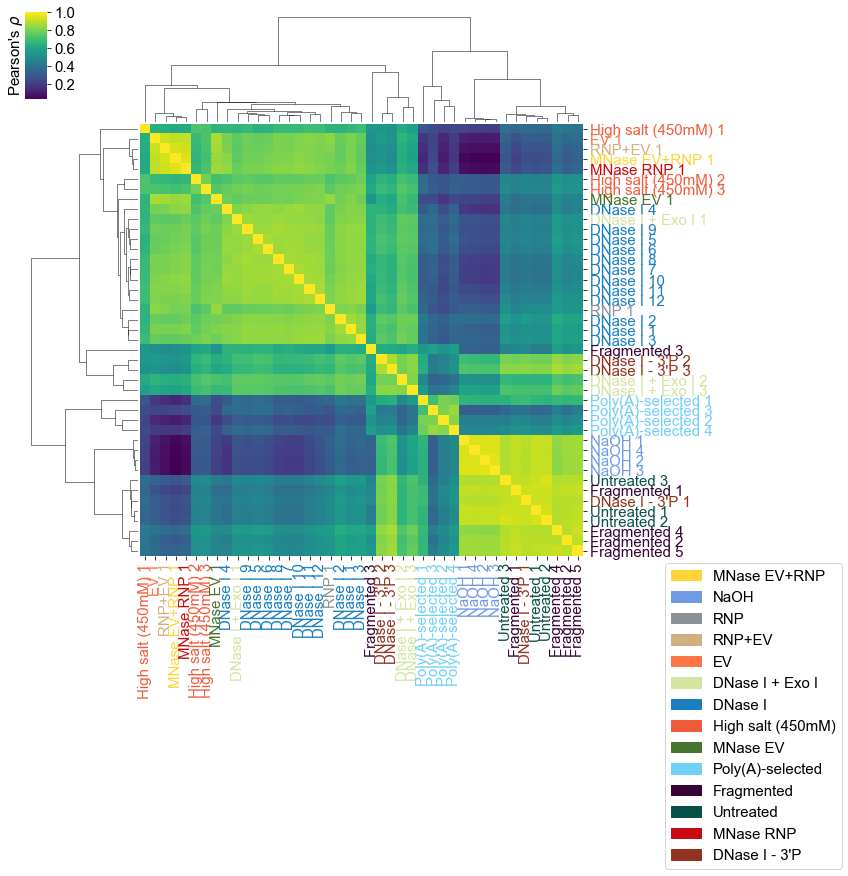

In [7]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [218]:
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')


filter_feature = 'No features' 
dedup_regex = ':dedup:' 
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','MT'])])\
        .groupby(['gene_id','gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos')\
        .pipe(normalize_count)\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id','gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') 
norm_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:357: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:380: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF1_R1_001:dedup:sense,64208.448546
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,QCF1_R1_001:dedup:sense,142371.194202
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,QCF1_R1_001:dedup:sense,40217.202795
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,QCF1_R1_001:dedup:sense,44085.900636
4,ENSG00000194270.1,Y_RNA,misc_RNA,Other sncRNA,QCF1_R1_001:dedup:sense,0.000000


In [219]:
rRNA_df = norm_df.query('grouped_type =="rRNA"') \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .reset_index(drop=True) 
rRNA_df.head()

,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count,prep
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF1_R1_001:dedup:sense,64208.448546,DNase I
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,QCF1_R1_001:dedup:sense,142371.194202,DNase I
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,QCF1_R1_001:dedup:sense,40217.202795,DNase I
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,QCF1_R1_001:dedup:sense,44085.900636,DNase I
4,ENSG00000199334.1,RNA5S11,rRNA,rRNA,QCF1_R1_001:dedup:sense,0.000000,DNase I


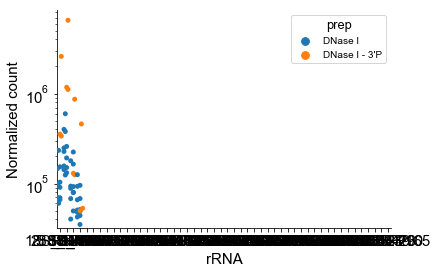

In [220]:
ax = plt.subplot(111)
sns.swarmplot(data = rRNA_df, 
              x = 'gene_name', 
              y = 'norm_count',
              dodge=True,
              hue='prep', ax =ax)
ax.set_yscale('log')
ax.set_ylabel('Normalized count')
ax.set_xlabel('rRNA')
sns.despine()

In [221]:
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-T'),'Mt-tRNA',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','Mt','Mt-tRNA'])])\
        .groupby(['gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos|^[MP]P')\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') \
        .assign(prep = lambda d: d.samplename.map(label_sample)) 
norm_df.head()

,gene_name,gene_type,grouped_type,samplename,norm_count,prep
0,18S_rRNA,18S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,5122,RNP+EV
1,28S_rRNA,28S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,7910,RNP+EV
2,5.8S_rRNA,5.8S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,6671,RNP+EV
3,5S_rRNA,5S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,3709,RNP+EV
4,5S_rRNA,rRNA,rRNA,MPCEV_R1_001:dedup:sense,0,RNP+EV


In [222]:
norm_plot_df = norm_df \
    .groupby(['grouped_type','samplename'], as_index=False)\
    .agg({'norm_count':'sum'}) \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(cpm = lambda d: d.groupby('samplename').norm_count.transform(lambda x: 1e6*x/x.sum()))
norm_plot_df.head()

,grouped_type,samplename,norm_count,prep,cpm
0,Mt,MPCEV_R1_001:dedup:sense,27,RNP+EV,34.917962
1,Mt,MPF10_R1_001:dedup:sense,119,RNP,220.836171
2,Mt,MPF4_R1_001:dedup:sense,16,EV,40.792704
3,Mt,PPCEV_R1_001:dedup:sense,382,MNase EV+RNP,114.243366
4,Mt,PPF10_R1_001:dedup:sense,714,MNase RNP,170.759473


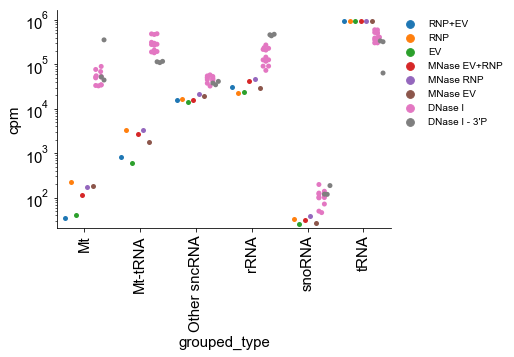

In [223]:
ax = plt.subplot(111)
sns.swarmplot(data=norm_plot_df, hue ='prep', 
              x = 'grouped_type', y ='cpm',
             dodge=True)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [243]:
pi_df = norm_df\
    .groupby(['gene_type','prep','samplename'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .pipe(lambda d: d[d.samplename.str.contains('^[Qq][cC][fF][0-9]+')])\
    .assign(norm_fraction = lambda d: d.groupby(['prep','samplename']).norm_count.transform(lambda x: 100*x/x.sum())) \
    .pipe(lambda d: d[d.gene_type.str.contains('rRNA')])\
    .pipe(lambda d: d[~d.gene_type.str.contains('Mt')])\
    .groupby(['gene_type'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .assign(fraction = lambda d: d.norm_count.transform(lambda x: 100*x/x.sum()))
pi_df.head()

,gene_type,norm_count,fraction
0,18S_rRNA,1420946,20.412031
1,28S_rRNA,3415094,49.058167
2,5.8S_rRNA,1272291,18.276587
3,5S_rRNA,852985,12.253215
4,rRNA,0,0.000000


In [231]:
68+25

93

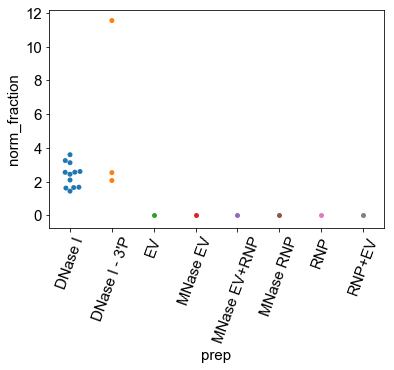

In [133]:
ax = plt.subplot()
sns.swarmplot(data = pi_df, x = 'prep',y = 'norm_fraction', ax=ax)
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

In [140]:
x = pi_df.query('prep=="DNase I"').norm_fraction.tolist()
y = pi_df.query('prep=="DNase I - 3\'P"').norm_fraction.tolist()
from scipy.stats import ranksums

ranksums(x,y)

RanksumsResult(statistic=-0.5773502691896258, pvalue=0.5637028616507731)

In [139]:
dedup_df                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))

[1.434983283421318, 1.6198651764246308, 3.5947964362618197, 3.1210704937816502, 1.6479608963517027, 1.6700716850832549, 2.4392852876492706, 2.5587086971573645, 3.2479878319285125, 2.0953343430105003, 2.6006187331820376, 2.5516041405653516] []
